# Reading a Neon dataset/recording
In this tutorial, we will show how to load a single Neon recording downloaded from [Pupil Cloud](https://docs.pupil-labs.com/neon/pupil-cloud/).

## Reading sample data
We will use a sample recording produced by the NCC Lab called `OfficeWalk`. It's a project with 2 recordings and multiple enrichments and can be downloaded with the `get_sample_data()` function. It returns a `Pathlib.Path` object to the downloaded & unzipped directory.

In [1]:
from pyneon import get_sample_data, NeonDataset, NeonRecording

sample_dir = get_sample_data("OfficeWalk")

The `OfficeWalk` data has the following structure:

```plaintext
OfficeWalk
├── Timeseries Data
│   ├── walk1-e116e606
│   │   ├── info.json
│   │   ├── gaze.csv
│   │   └── ....
│   ├── walk2-93b8c234
│   │   ├── info.json
│   │   ├── gaze.csv
│   │   └── ....
|   ├── enrichment_info.txt
|   └── sections.csv
├── OfficeWalk_FACE-MAPPER_FaceMap
├── OfficeWalk_MARKER-MAPPER_TagMap_csv
└── OfficeWalk_STATIC-IMAGE-MAPPER_ManualMap_csv
```

The `Timeseries Data` folder contains what PyNeon calls a `NeonDataset`. It contains multiple recordings, each with its own `info.json` file and data files. These recordings can either be loaded individually as a `NeonRecording` as a wholist `NeonDataset`.

If loading a `NeonDataset`, specify the path to the `Timeseries Data` folder to create a `NeonDataset` object:

In [2]:
dataset_dir = sample_dir / "Timeseries Data"
dataset = NeonDataset(dataset_dir)
print(dataset)

NeonDataset | 2 recordings


NeonDataset has a `recordings` attribute that contains a list of `NeonRecording` objects. These `NeonRecording` objects can be accessed by their index.

In [3]:
first_recording = dataset[0]
print(type(first_recording))

<class 'pyneon.recording.NeonRecording'>


Equivalently, one can directly load a single `NeonRecording` by specifying the path to the recording's folder.

In [4]:
recording_dir = dataset_dir / "walk1-e116e606"
recording = NeonRecording(recording_dir)
print(type(recording))

<class 'pyneon.recording.NeonRecording'>


## Data and metadata of a NeonRecording
An overview of basic metadata and contents of a `NeonRecording` can be obtained by printing the object. An initiated `NeonRecording` locates data files in the recording directory but does not load them until requested to be memory efficient.

In [5]:
print(recording)


Recording ID: e116e606-5f3f-4d34-8727-040b8762cef8
Wearer ID: bcff2832-cfcb-4f89-abef-7bbfe91ec561
Wearer name: Qian
Recording start time: 2024-08-30 17:37:01.527000
Recording duration: 98.213s
                  exist              filename                                                                                  path
3d_eye_states      True     3d_eye_states.csv     D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\3d_eye_states.csv
blinks             True            blinks.csv            D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\blinks.csv
events             True            events.csv            D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\events.csv
fixations          True         fixations.csv         D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\fixations.csv
gaze               True              gaze.csv              D:\GitHub\pyneon\data\OfficeWalk\Timeseries Data\walk1-e116e606\gaze.csv
imu          

As seen in the output, this recording contains every file other than the scene video. This is because we downloaded the "Timeseries Data" instead of "Timeseries Data + Scene Video" from Pupil Cloud. For more information on how to process video files, see the [video tutorial](video.ipynb).

Individual data streams can be accessed as properties of the `NeonRecording` object. For example, the gaze data can be accessed as `recording.gaze`, and upon accessing, the tabular data is loaded into memory. On the other hand, if you try to access unavailable data like the video, it will simply return `None` and a warning message.

In [6]:
gaze = recording.gaze
print(gaze)
video = recording.video
print(video)

None


D:\GitHub\pyneon\pyneon\recording.py:275: UserWarning: Scene video not loaded because no video or video timestamps file was found.
  warnings.warn(


We can access the timeseries data in the gaze stream as a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) by accessing the `data` attribute of the gaze stream. The DataFrame has the datetime of each data point as its index. The raw UTC `timestamp [ns]` is available as a column along with data from channnels like `gaze x [px]`.

During loading, PyNeon strips the redundant `section id` and `recording id` columns and adds a more human-readable `time [s]` column to represent the time of each sample in seconds relative to the start of the data stream.

In [7]:
print(gaze.data.head())

                     gaze x [px]  gaze y [px]  worn  fixation id  blink id  \
timestamp [ns]                                                               
1725032224852161732     1067.486      620.856  True            1      <NA>   
1725032224857165732     1066.920      617.117  True            1      <NA>   
1725032224862161732     1072.699      615.780  True            1      <NA>   
1725032224867161732     1067.447      617.062  True            1      <NA>   
1725032224872161732     1071.564      613.158  True            1      <NA>   

                     azimuth [deg]  elevation [deg]  
timestamp [ns]                                       
1725032224852161732      16.213030        -0.748998  
1725032224857165732      16.176285        -0.511733  
1725032224862161732      16.546413        -0.426618  
1725032224867161732      16.210049        -0.508251  
1725032224872161732      16.473521        -0.260388  


PyNeon also automatically sets the column datatype to appropriate types, such as `Int64` for timestamps, `Int32` for event IDs, and `float64` for float data.

In [8]:
print(gaze.data.dtypes)

gaze x [px]        float64
gaze y [px]        float64
worn                  bool
fixation id          Int32
blink id             Int32
azimuth [deg]      float64
elevation [deg]    float64
dtype: object


## Data streams and events

Up to this point, PyNeon simply reads and re-organizes the raw .csv files. Let's plot some samples from the `gaze` and `eye_states` streams and a saccade from the `saccades` events.

saccade id                                2.0
end timestamp [ns]      1725032225347526656.0
duration [ms]                            65.0
amplitude [px]                      228.36139
amplitude [deg]                     14.676102
mean velocity [px/s]              3685.269894
peak velocity [px/s]              5411.775481
Name: 1725032225282527732, dtype: Float64


TypeError: unhashable type: 'numpy.ndarray'

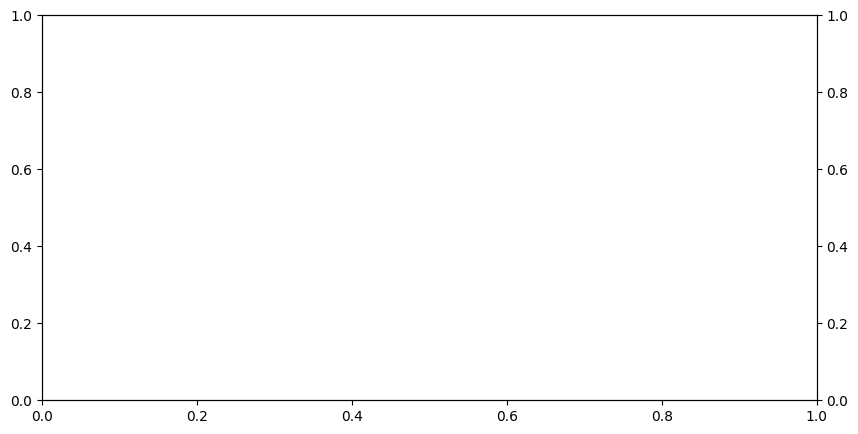

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

gaze_color = "royalblue"
gyro_color = "darkorange"

imu = recording.imu
saccades = recording.saccades

# Create a figure
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()
ax.yaxis.label.set_color(gaze_color)
ax2.yaxis.label.set_color(gyro_color)

# Visualize the 2nd saccade
saccade = saccades.data.iloc[1]
print(saccade)
ax.axvspan(saccade.index.values, saccade["end timestamp [ns]"], color="lightgray")
ax.text(
    (saccade.index.values + saccade["end timestamp [ns]"]) / 2,
    1050,
    "Saccade",
    horizontalalignment="center",
)

# Visualize gaze x and pupil diameter left
sns.scatterplot(
    ax=ax,
    data=gaze.data.head(100),
    x=gaze.data.index,
    y="gaze x [px]",
    color=gaze_color,
)
sns.scatterplot(
    ax=ax2,
    data=imu.data.head(60),
    x=imu.data.index,
    y="gyro x [deg/s]",
    color=gyro_color,
)

It's apparent that at the beginning of the recording, there are some missing data points in both the `gaze` and `imu` streams. This is presumably due to the time it takes for the sensors to start up and stabilize. We will show how to handle missing data using resampling in the next tutorial. For now, it's important to be aware of these gaps and that it will require great caution to assume the data is continuously and equally sampled.

PyNeon also calculates the effective (as opposed to the nominal) sampling frequency of each stream by dividing the number of samples by the duration of the recording.

In [10]:
print(
    f"Gaze: nominal sampling frequency = {gaze.sampling_freq_nominal}, "
    f"effective sampling frequency = {gaze.sampling_freq_effective}"
)
print(
    f"IMU: nominal sampling frequency = {recording.imu.sampling_freq_nominal}, "
    f"effective sampling frequency = {recording.imu.sampling_freq_effective}"
)

Gaze: nominal sampling frequency = 200, effective sampling frequency = 197.8078038925275
IMU: nominal sampling frequency = 110, effective sampling frequency = 115.35532450871617


## Visualizing gaze heatmap
Finally, we will show how to plot a heatmap of the gaze/fixation data.

C:\Users\qian.chu\Documents\GitHub\pyneon\pyneon\recording.py:275: UserWarning: Scene video not loaded because no video or video timestamps file was found.
  warnings.warn(


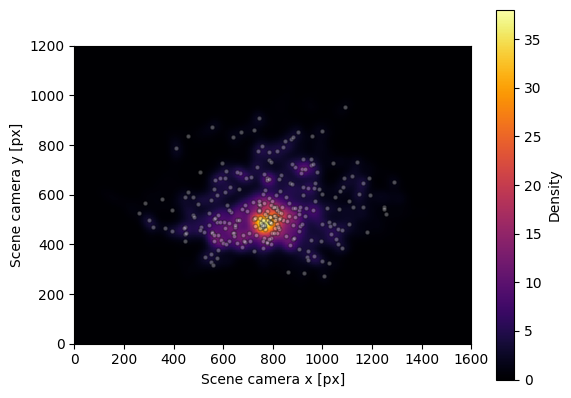

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Scene camera x [px]', ylabel='Scene camera y [px]'>)

In [11]:
recording.plot_distribution()

we can neatly see that the recorded data shows a centre-bias, which is a well-known effect from eye statistics. In y, we can see that fixations tend to occur below the horizon, which is indicative of a walking task where a participant looks at the floor in front of them more often